In [1]:
%%capture
!pip install transformers

In [2]:
try:
    import pandas as pd
    import torch
    import os
    import json
    import numpy as np
    from transformers import BertTokenizer, BertModel
    from torch import nn
    from torch.optim import Adam
    from tqdm import tqdm
    
except Exception as E:
    print('Some modules not found')
    print(E)

In [3]:
train_path = '../smart-2022-datasets/AT_answer_type_prediction/dbpedia/SMART2022-AT-dbpedia-train.json'

In [4]:
with open(train_path, 'r') as f:
    at_db_train = json.load(f)

In [5]:
at_db_train

[{'id': 0,
  'question': 'Was Jacqueline Kennedy Onassis a follower of Melkite Greek Catholic Church?',
  'category': 'boolean',
  'type': ['boolean']},
 {'id': 1,
  'question': 'What is the name of the opera based on Twelfth Night ?',
  'category': 'resource',
  'type': ['dbo:Opera', 'dbo:MusicalWork', 'dbo:Work']},
 {'id': 2,
  'question': 'When did Lena Horne receive the Grammy Award for Best Jazz Vocal Album?',
  'category': 'literal',
  'type': ['date']},
 {'id': 3,
  'question': 'Do Prince Harry and Prince William have the same parents?',
  'category': 'boolean',
  'type': ['boolean']},
 {'id': 5,
  'question': 'Which is the hierarchical BrainInfo ID of the frontal lobe?',
  'category': 'literal',
  'type': ['string']},
 {'id': 6,
  'question': 'What is the federated state located in the Weimar Republic?',
  'category': 'resource',
  'type': ['dbo:State', 'dbo:PopulatedPlace', 'dbo:Place', 'dbo:Location']},
 {'id': 7,
  'question': 'Did Buddhism was named after the immigration of

In [6]:
category = []

text = []

for entry in at_db_train:
    text.append(entry['question'])
    if entry['category'] == 'literal':
        _type = entry['type']
        category.append(entry['category']+_type[0])
    else:
        category.append(entry['category'])

In [7]:
data = {'category': category, 'text': text}
df = pd.DataFrame(data)
df.head()

,category,text
0,boolean,Was Jacqueline Kennedy Onassis a follower of M...
1,resource,What is the name of the opera based on Twelfth...
2,literaldate,When did Lena Horne receive the Grammy Award f...
3,boolean,Do Prince Harry and Prince William have the sa...
4,literalstring,Which is the hierarchical BrainInfo ID of the ...


<AxesSubplot:xlabel='category'>

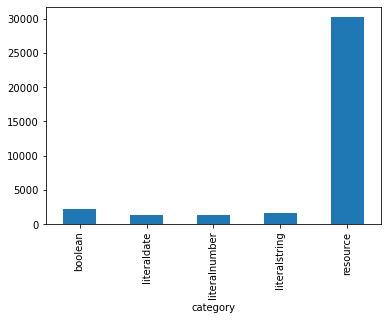

In [8]:
df.groupby(['category']).size().plot.bar()

In [9]:

%%capture

os.environ["CURL_CA_BUNDLE"]=""
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'boolean':0,
          'literaldate':1,
          'literalnumber':2,
          'literalstring':3,
          'resource':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_y = np.array(self.labels[idx])

        return batch_texts, batch_y

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [11]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [12]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [13]:
df.sample(frac=1, random_state=42)

,category,text
34165,resource,what language is the great indian butterfly in
20305,resource,what kingdom was involved in battle of restigo...
33373,resource,Who was born in boston?
22876,resource,who is the fbi translator born in iran?
19424,resource,Where is bob van dillen from
...,...,...
16850,resource,who does michael oher play for in 2010
6265,literalstring,Which is the ICD-9-CM for migraine?
11284,literaldate,When did Pamplona become the capital of Navarre?
860,resource,Give me all Dutch parties.


In [14]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

29336 3667 3667


In [15]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

/home/hitachi/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'umproxy.prx.intra.hitachi.co.jp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/hitachi/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'umproxy.prx.intra.hitachi.co.jp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm

Epochs: 1 | Train Loss:  0.053 | Train Accuracy:  0.868 | Val Loss:  0.028 | Val Accuracy:  0.954


100%|███████████████████████████████████████| 3667/3667 [28:03<00:00,  2.18it/s]


Epochs: 2 | Train Loss:  0.016 | Train Accuracy:  0.975 | Val Loss:  0.013 | Val Accuracy:  0.975


100%|███████████████████████████████████████| 3667/3667 [28:03<00:00,  2.18it/s]


Epochs: 3 | Train Loss:  0.009 | Train Accuracy:  0.984 | Val Loss:  0.011 | Val Accuracy:  0.980


100%|███████████████████████████████████████| 3667/3667 [28:04<00:00,  2.18it/s]


Epochs: 4 | Train Loss:  0.006 | Train Accuracy:  0.989 | Val Loss:  0.010 | Val Accuracy:  0.980


100%|███████████████████████████████████████| 3667/3667 [28:04<00:00,  2.18it/s]


Epochs: 5 | Train Loss:  0.005 | Train Accuracy:  0.992 | Val Loss:  0.011 | Val Accuracy:  0.981


In [16]:
evaluate(model, df_test)

Test Accuracy:  0.978


# Confusion matrix

In [44]:
class Dataset2(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
        self.question = text

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_y = np.array(self.labels[idx])
        batch_question = self.question[idx]

        return batch_texts, batch_y, batch_question

test = Dataset2(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    model = model.cuda()

preds = []
gts = []

total_acc_test = 0
with torch.no_grad():

    for test_input, test_label, question in test_dataloader:
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        

        preds.append(output.argmax(dim=1).item())
        if (output.argmax(dim=1).item() != test_label.item()) and (test_label.item()==1):
            print(question, output.argmax(dim=1).item(), test_label.item())
        gts.append(test_label.item())

('What is the dredger with the highest payload mass?',) 4 1
('Which school of jack mcGregor attend which was also the training center of William Anthony ?',) 2 1
('How many names are there for Kang Youwei?',) 0 1
('Give me the number of home stadiums of teams managed by John Spencer.',) 4 1
("did halle berry received the award of monster's ball?",) 2 1
('When did Kylie Minogue receive the Gold Logie Award for Most Popular Personality on Australian Television?',) 4 1
('Beechland Beach is located in what town?',) 4 1
('What is the Nationlamuseum Sweden artist ID for Jean Arp',) 4 1
('who is the discoverer or inventor of gamma function?',) 4 1
('What is the IOC code for Country Gabon?',) 4 1
('What is the baseball team whose club manager is Chip Hale?',) 4 1
('What are the organisation founded in Texas and Dallas?',) 4 1
("What is the cat films shot of One Flew Over the Cuckoo's Nest?",) 4 1
('Is KOMC-FM the sister station of KOMC (AM)?',) 4 1
('When did John W. Henry become the owner of 

In [49]:
df[df['text']=='What is the Nationlamuseum Sweden artist ID for Jean Arp']

,category,text
998,literalstring,What is the Nationlamuseum Sweden artist ID fo...


In [33]:
_preds = []
_gts = []
for x in range(len(preds)):
    temp1 = preds[x].detach().cpu().tolist()
    temp2 = gts[x].detach().cpu().tolist()
    for i in range(len(temp1)):
        _preds.append(temp1[i])
        _gts.append(temp2[i])

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(_gts, _preds)

array([[ 193,    0,    1,    1,    8],
       [   1,  110,    1,    0,   19],
       [   0,    1,  126,    3,   11],
       [   2,    1,    4,  150,   10],
       [   5,    5,    8,    3, 3004]])

<AxesSubplot:xlabel='category'>

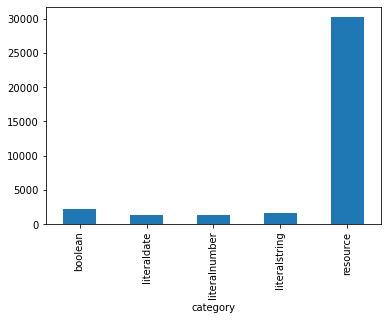

In [38]:
df.groupby(['category']).size().plot.bar()

In [50]:
type(model)

__main__.BertClassifier

In [53]:
torch.save(model.state_dict(), 'bertATmodel.pt')

In [54]:
!ls

bbc-text.csv	  bert_medium_post.ipynb	 MODIFIED_bert_medium_AT.ipynb
bbc-text.csv.zip  bookmarks_windows_hitachi.txt  README.md
bertATmodel	  dbpedia_EDA_AT-26Aug.ipynb	 wikidata_EDA_AT.ipynb
bertATmodel.pt	  dbpedia_EDA_AT.ipynb
